In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#构建模型
def fc_forward(z, W, b):
    return np.dot(z, W) + b

def relu_forward(z):
    return np.maximum(0, z)

def forward(X,nuerons):
    nuerons["z2"]=fc_forward(X,weights["W1"],weights["b1"])
    nuerons["z2_relu"]=relu_forward(nuerons["z2"])
    nuerons["y"]=fc_forward(nuerons["z2_relu"],weights["W2"],weights["b2"])
    return nuerons["y"]

def fc_backward(next_dz, W, z):
    N = z.shape[0]
    dz = np.dot(next_dz, W.T)  
    dw = np.dot(z.T, next_dz)  
    db = np.sum(next_dz, axis=0)  
    return dw / N, db / N, dz

def relu_backward(next_dz, z):
    dz = np.where(np.greater(z, 0), next_dz, 0)
    return dz

def cross_entropy_loss(y_predict,y_true):
    y_shift = y_predict - np.max(y_predict, axis=-1, keepdims=True)
    y_exp = np.exp(y_shift)
    y_probability = y_exp / np.sum(y_exp, axis=-1,keepdims=True)
    loss = np.mean(np.sum(-y_true * np.log(y_probability), axis=-1))  # 损失函数
    dy = y_probability - y_true
    return loss, dy

def backward(X,y_true,nuerons,gradients):
    loss,dy=cross_entropy_loss(nuerons["y"],y_true)
    gradients["W2"],gradients["b2"],gradients["z2_relu"]=fc_backward(dy,weights["W2"],nuerons["z2_relu"])
    gradients["z2"]=relu_backward(gradients["z2_relu"],nuerons["z2"])
    gradients["W1"],gradients["b1"],_=fc_backward(gradients["z2"],
                                                    weights["W1"],X)
    return loss, gradients

def get_accuracy(X,y_true,nuerons):
    y_predict=forward(X,nuerons)
    return np.mean(np.equal(np.argmax(y_predict,axis=-1),
                            np.argmax(y_true,axis=-1)))

def modelSaving(file,weights,lr,factor):
    params = weights
    params['lr'] = lr
    params['decay_rate'] = factor
    np.save(file, params)

def modelLoading(file):
    params = np.load(file, allow_pickle=True).item()
    return params

In [3]:
import struct
def load_images(file_name):
    with open(file_name,'rb') as binfile:
        buffers = binfile.read()
        magic, num,rows, cols = struct.unpack_from('>IIII',buffers,0)
        bits = num*rows*cols
        images = struct.unpack_from('>'+str(bits)+'B',buffers,struct.calcsize('>IIII'))
        images = np.reshape(images,[num,rows*cols])
        return images
def load_labels(file_name):
    ##   打开文件
    binfile = open(file_name, 'rb')
    ##   从一个打开的文件读取数据    
    buffers = binfile.read()
    ##   读取label文件前2个整形数字，label的长度为num
    magic,num = struct.unpack_from('>II', buffers, 0) 
    ##   读取labels数据
    labels = struct.unpack_from('>' + str(num) + "B", buffers, struct.calcsize('>II'))
    ##   关闭文件
    binfile.close()
    ##   转换为一维数组
    labels = np.reshape(labels, [num])
    return labels    

In [4]:
#图像和标签的地址
filename_train_images = 'C:\\Users\\46135\\Desktop\\研一下\\神经网络\\homework1\\data\\train-images-idx3-ubyte'
filename_train_labels = 'C:\\Users\\46135\\Desktop\\研一下\\神经网络\\homework1\\data\\train-labels-idx1-ubyte'
filename_test_images = 'C:\\Users\\46135\\Desktop\\研一下\\神经网络\\homework1\\data\\t10k-images-idx3-ubyte'
filename_test_labels = 'C:\\Users\\46135\\Desktop\\研一下\\神经网络\\homework1\\data\\t10k-labels-idx1-ubyte'
train_images=load_images(filename_train_images)
train_labels=load_labels(filename_train_labels)
test_images=load_images(filename_test_images)
test_labels=load_labels(filename_test_labels)
train_set = [train_images, train_labels]
test_set = [test_images, test_labels]

In [5]:
def to_categorical(y, num_classes=None):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=np.float32)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [6]:
train_num = train_set[0].shape[0]
train_y,test_y=to_categorical(train_set[1]),to_categorical(test_set[1])
def next_batch(batch_size):
    idx=np.random.choice(train_num,batch_size)
    return train_set[0][idx],train_y[idx]

In [7]:
# 初始化变量
weights={}
weights_scale=1e-3
weights["W1"]=weights_scale*np.random.randn(28*28,382)
weights["b1"]=np.zeros(382)
weights["W2"]=weights_scale*np.random.randn(382,10)
weights["b2"]=np.zeros(10)

batch_size=32
epoch = 8
steps = train_num // batch_size
lr = 0.005#学习率
factor = 0.5#衰减因子

def train(batch_size,epoch,steps,lr,factor,weights):
    nuerons={}
    gradients={}
    train_loss = []
    train_acc = []
    test_acc = []
    lr_rate = []
    lr_ = lr
    for e in range(epoch):
        if e%2==0:
            lr_ = max(5*1e-4,lr_*factor)
            
        for s in range(steps):
            X,y=next_batch(batch_size)

            # 前向过程
            forward(X,nuerons)
            loss, graidents = backward(X,y,nuerons,gradients)

            # 更新梯度
            for k in ["W1","b1","W2","b2"]:
                weights[k]-=lr_*gradients[k]


            if s % 2000 ==0:
                print("\n epoch:{} step:{} ; loss:{}".format(e,s,loss))
                print(" train_acc:{};  test_acc:{}; lr:{}".format(get_accuracy(X,y,nuerons),get_accuracy(test_set[0],test_y,nuerons),lr_))
            if s % 100 ==0:
                train_loss.append(loss)
                train_acc.append(get_accuracy(X,y,nuerons))
                test_acc.append(get_accuracy(test_set[0],test_y,nuerons))

            lr_rate.append(lr_)
    print("\n final result test_acc:{};  test_acc:{}".
          format(get_accuracy(test_set[0],test_y, nuerons),get_accuracy(test_set[0],test_y,nuerons)))


    modelSaving('./model',weights,lr,factor)
    return train_loss, train_acc, test_acc, lr_rate

def classify(x,y_true,weights):
    x1 = fc_forward(x,weights['W1'],weights['b1'])
    z1 = relu_forward(x1)
    x2 = fc_forward(z1,weights['W2'],weights['b2'])
    y = relu_forward(x2)
    y_pred = np.argmax(y,axis=-1)
    print('The result is {}; The true label is {}'.format(y_pred, y_true))

In [8]:
#训练
train_loss, train_acc, test_acc, lr_rate = train(batch_size,epoch,steps,lr,factor,weights)


 epoch:0 step:0 ; loss:2.2998916245143226
 train_acc:0.46875;  test_acc:0.2059; lr:0.0025

 epoch:1 step:0 ; loss:0.09154364136805114
 train_acc:1.0;  test_acc:0.9561; lr:0.0025

 epoch:2 step:0 ; loss:0.00335136305456493
 train_acc:1.0;  test_acc:0.9724; lr:0.00125

 epoch:3 step:0 ; loss:0.049195969737311204
 train_acc:1.0;  test_acc:0.9769; lr:0.00125

 epoch:4 step:0 ; loss:0.005193809737848904
 train_acc:1.0;  test_acc:0.9802; lr:0.000625

 epoch:5 step:0 ; loss:0.002024329953556289
 train_acc:1.0;  test_acc:0.9807; lr:0.000625

 epoch:6 step:0 ; loss:0.004505290670066332
 train_acc:1.0;  test_acc:0.9826; lr:0.0005

 epoch:7 step:0 ; loss:0.250056107508175
 train_acc:0.96875;  test_acc:0.9818; lr:0.0005

 final result test_acc:0.9828;  test_acc:0.9828


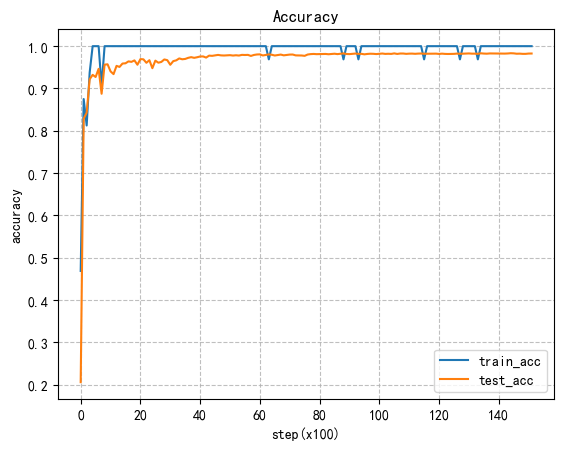

In [18]:
#可视化
figure,ax = plt.subplots()
ax.plot(train_acc)
ax.plot(test_acc)
plt.xlabel('step(x100)')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(['train_acc','test_acc'])
ax.grid(linestyle='--',alpha=0.8)
plt.savefig('Accuracy' + '.jpg')
plt.show()
plt.close()

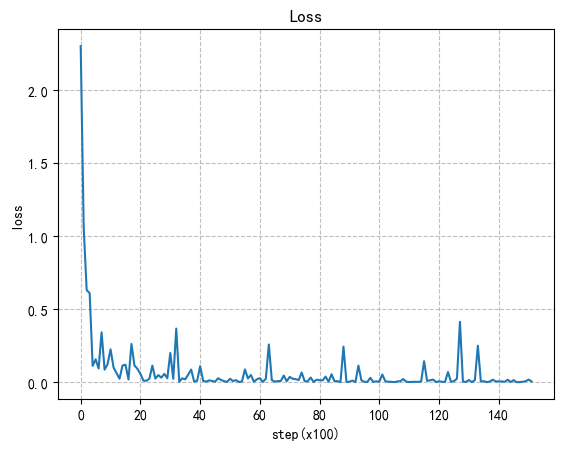

In [17]:
plt.plot(train_loss)
plt.ylabel('loss')
plt.xlabel('step(x100)')
plt.title('Loss')
plt.grid(linestyle='--',alpha=0.8)
plt.savefig('Loss' + '.jpg')
plt.show()
plt.close()

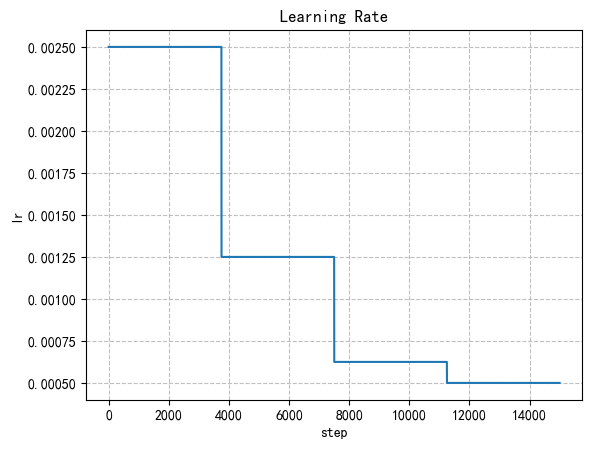

In [16]:
plt.plot(lr_rate)
plt.grid(linestyle='--',alpha=0.8)
plt.xlabel('step')
plt.ylabel('lr')
plt.title('Learning Rate')
plt.show()
plt.savefig('Learning Rate' + '.jpg')
plt.close()

In [12]:
#可视化参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 防止图例中文乱码
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
plt.imshow(weights['b2'].reshape(1, -1), cmap='Greys', interpolation=None)
plt.savefig('b2' + '.jpg')
plt.close()
plt.imshow(weights['b1'].reshape(1, -1), cmap='Greys', interpolation=None)
plt.savefig('b1' + '.jpg')
plt.close()
plt.imshow(weights['W2'], cmap='Greys', interpolation=None)
plt.savefig('W2' + '.jpg')
plt.close()
plt.imshow(weights['W1'], cmap='Greys', interpolation=None)
plt.savefig('W1' + '.jpg')
plt.close()

In [13]:
#导入训练好的模型进行测试
weights = modelLoading('./model.npy')
i = np.random.choice(np.arange(1000))
x = train_images[i,:]
y = train_labels[i]
classify(x,y,weights)

The result is 2; The true label is 2
